<a href="https://colab.research.google.com/github/MrckHckr/artemis2-go-tests/blob/main/notebooks/01_sls_propulsion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test SLS – Propulsione e Strutture
Core Stage (RS‑25)

Obiettivo: probabilità di failure < 1 su 500

Test:
1. Hot Fire Test (green run)
2. Vibrazioni strutturali
3. Thermal cycling
4. Analisi Data Science
5. Survival analysis
6. Anomaly detection su pressioni e temperature

In [2]:
# Import delle librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import weibull_min
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

np.random.seed(42)



1. Hot Fire Test (green run)

In [3]:
# Dati Hot Fire Test
n_tests = 500

shape = 3.0
scale = 1200

time_to_failure = weibull_min.rvs(shape, scale=scale, size=n_tests)

df_life = pd.DataFrame({
    "test_id": range(n_tests),
    "time_to_failure_sec": time_to_failure
})

df_life.head()


,test_id,time_to_failure_sec
0,0,932.513055
1,1,1732.643650
2,2,1315.270910
3,3,1164.114583
4,4,664.269668


In [4]:
# Survival Analysis (Weibull)
params = weibull_min.fit(df_life["time_to_failure_sec"], floc=0)
shape_hat, loc_hat, scale_hat = params

shape_hat, scale_hat


(np.float64(2.932949072830869), np.float64(1197.887689822981))

In [5]:
# Probabilità di failure durante il lancio
mission_time = 520

p_failure = weibull_min.cdf(mission_time, shape_hat, scale=scale_hat)

print(f"P(failure) = {p_failure:.6f}")
print(f"≈ 1 su {1/p_failure:.0f}")


P(failure) = 0.082873
≈ 1 su 12


In [6]:
# Simulazione sensori (pressione & temperatura)
time = np.arange(0, 520)

pressure = np.random.normal(3000, 50, size=len(time))
temperature = np.random.normal(3300, 40, size=len(time))

pressure[120] += 300
temperature[350] += 250
pressure[480] -= 400

df_sensors = pd.DataFrame({
    "time_sec": time,
    "pressure": pressure,
    "temperature": temperature
})

df_sensors.head()


,time_sec,pressure,temperature
0,0,3017.087799,3245.605754
1,1,3093.808542,3329.850143
2,2,3047.521192,3325.819367
3,3,2971.154817,3386.530189
4,4,2955.079266,3287.688871


In [7]:
# Anomaly Detection
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_sensors[["pressure", "temperature"]])

model = IsolationForest(contamination=0.01, random_state=42)
df_sensors["anomaly"] = model.fit_predict(X_scaled)


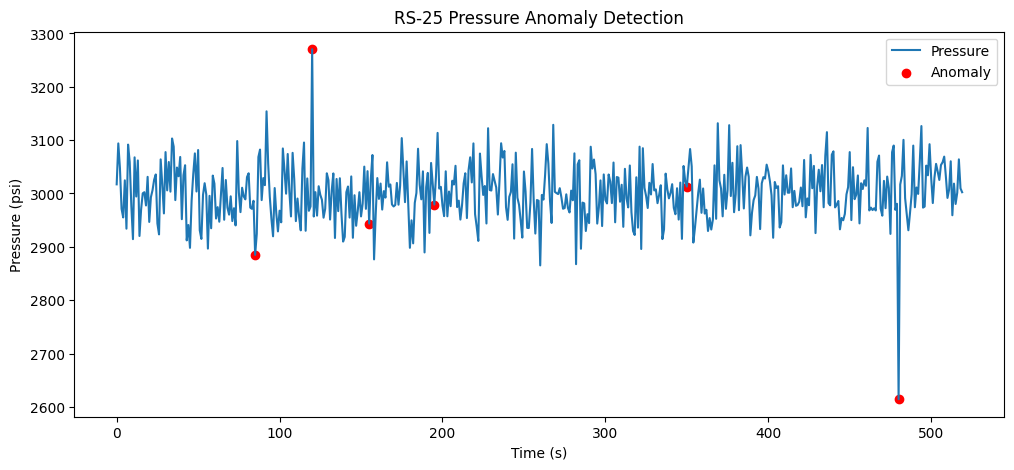

In [8]:
# Visualizzazione anomalie
plt.figure(figsize=(12,5))
plt.plot(df_sensors["time_sec"], df_sensors["pressure"], label="Pressure")
plt.scatter(
    df_sensors[df_sensors["anomaly"] == -1]["time_sec"],
    df_sensors[df_sensors["anomaly"] == -1]["pressure"],
    color="red",
    label="Anomaly"
)
plt.xlabel("Time (s)")
plt.ylabel("Pressure (psi)")
plt.legend()
plt.title("RS-25 Pressure Anomaly Detection")
plt.show()
